# YOLO v9 Detection Model For Google Coral and Frigate

This notebook generates a YOLO v9 model ready to run on a Google Coral TPU for detecting objects in Frigate.

**Key Features**
- **Accurate:** (in my own use) YOLO v9 has **fewer false positive** detections than the default model provided by Frigate for Google Coral.
- **Fast:** achieves **11ms inference latency** because the Google Coral TPU runs most of the YOLO v9 model operations.
- **Free to use and distribute:** The starting point is the YOLO v9 pre-trained model and weights from [WongKinYiu](https://github.com/WongKinYiu/yolov9) which is GPL licensed and that enables this repo to be **MIT licensed** (same license as Frigate).

**How Does It Work?**
- **Fixes Quantization Issue:** Building a model for Google Coral requires special handling to address two challenges: (1) limited data precision (INT8), and (2) quantization happens across the full tensor. If quantization goes wrong, then all of the scores have zero values and no objects get detected.
- **REQUIRES PATCHED DETECTOR PLUGIN: [See this github repository](https://github.com/dbro/frigate-detector-edgetpu-yolo9)** This Colab workbook corresponds to the v1.5 release in Github.

**Caveats**
- **Some operations happen outside the TPU:** To produce data ready for use by Frigate, the model uses some CPU instead of TPU to decode the box coordinates into XYWH format, as well as the NMS de-duplication. There is a [new patched version of Frigate's edgetpu detector plugin](https://github.com/dbro/frigate-detector-edgetpu-yolo9) and it post-processes the data in a way that is similar to Frigate's OpenVINO detector.

**References**
- [WongKinYiu's implementation of the YOLO v9 paper](https://github.com/WongKinYiu/yolov9)
- [onnx2tf transformation library](https://github.com/PINTO0309/onnx2tf)
  - [especially helpful was this discussion about loss of precision in the YOLOX model when doing integer quantization](https://github.com/PINTO0309/onnx2tf/issues/269#issuecomment-1483090981)

In [1]:
# ============================================================================
# STEP 1: Install Required Packages
# ============================================================================
print("Installing packages...")

# Core packages
!pip install -q "torch<=2.8.0" torchvision "onnx<=1.19.1" "onnxslim>=0.1.67"

# TensorFlow and related packages
!pip install -q "tensorflow>=2.0.0,<=2.19.0" "tf_keras<=2.19.0" "ai-edge-litert>=1.2.0" "onnxruntime-gpu"

# onnx2tf and dependencies
!pip install -q "sng4onnx>=1.0.1"
!pip install -q "onnx_graphsurgeon>=0.3.26" --extra-index-url https://pypi.ngc.nvidia.com
!pip install -q "onnx2tf>=1.26.3" "protobuf>=5" "mct-quantizers>=1.6.0"
!pip install -q sne4onnx
print("✓ Package installation complete!")

Installing packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 126.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [2]:
# ============================================================================
# STEP 3: Import Libraries and Check Versions
# ============================================================================
import sys
from pathlib import Path
import subprocess
print(f"python version: {sys.version}")
import torch
print(f"PyTorch version: {torch.__version__}")
import torch.nn as nn
import numpy as np
import onnx
print(f"ONNX version: {onnx.__version__}")
import onnxslim
import onnx2tf
print(f"onnx2tf version: {onnx2tf.__version__}")
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")



python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version: 2.8.0+cu128
ONNX version: 1.19.1
onnx2tf version: 1.28.5
TensorFlow version: 2.19.0


In [3]:
# ============================================================================
# STEP 4: DOWNLOAD YOLO v9-s Model Weights
# ============================================================================

IMGSZ = (320,320) # Limited to maximum 320x320 to fit on Google Coral device
BATCH_SIZE = 1
COCO_CLASSES_TO_KEEP = { # original COCO index, and COCO name
    '0' : 'person',
    '1' : 'bicycle',
    '2' : 'car',
    '3' : 'motorcycle',
    '4' : 'airplane',
    '5' : 'bus',
    '6' : 'train',
    '7' : 'truck',
    '8' : 'boat',
    '14' : 'bird',     # 15 in Frigate's standard labelmap.txt
    '15' : 'cat',      # 16
    '16' : 'dog',      # 17
    '17' : 'horse',    # 18
    '18' : 'sheep',    # 19
    '19' : 'cow',      # 20
    '20' : 'elephant', # 21
    '21' : 'bear',     # 22
}
NUM_CLASSES = len(COCO_CLASSES_TO_KEEP) # 17 classes out of 80 in standard COCO dataset

# Upload the model file created by fine-tuning the YOLO model to use ReLU and 17 COCO classes
# See here https://colab.research.google.com/drive/1RAZqCHuDWFdFxqFpL78OVfZQvnGoM6rH
MODEL_PATH = "yolov9-s-relu6-best.pt"
MODEL_URL = "https://github.com/dbro/frigate-detector-edgetpu-yolo9/releases/download/v1.0/yolov9-s-relu6-best.pt"
# (not recommended) Use the pre-trained model (has bad SiLU activation, and all 80 COCO classes)
#MODEL_PATH = "yolov9-s-converted.pt"
#MODEL_URL = "https://github.com/WongKinYiu/yolov9/releases/download/v0.1/" + MODEL_PATH
print(f"\nDownloading YOLO v9-s (GPL) from: {MODEL_URL}")
!wget -q {MODEL_URL} -O {MODEL_PATH}
print(f"✓ Model downloaded: {MODEL_PATH}")


✓ Model downloaded: yolov9-s-relu6-best.pt


In [4]:
# ===========================================================================
# STEP 4.5: Clone Original YOLOv9 Repo to Load Model Architecture
# ===========================================================================
# The .pt file was saved with a dependency on the original
# repository's code structure. We must clone the repo so that torch.load()
# can find the necessary model class definitions (e.g., in the 'models' module).
print("Cloning the original YOLOv9 repository for model definitions...")
!git clone -q https://github.com/WongKinYiu/yolov9.git
print("✓ Repository cloned.")

Cloning the original YOLOv9 repository for model definitions...
✓ Repository cloned.


# Add new head DualDDetectEdgeTPU

In [5]:
########################################
# Add new node to yolo model definition
########################################

print("="*70)
print("DualDDetectEdgeTPU - Single Combined Output")
print("="*70)
# This version combines normalized boxes [0,1] and scores [0,1]
# into a single output tensor for simpler export.

import os

LOGIT_CLAMP_MAX = 4.0
# a value of 4.0 here means the values for class scores will be limited
# to the range of -4.0 to +4.0, corresponding to the range [1.8%, 98.2%] probability
# and the 8-bit quantization will have 255 steps that span (no wider than)
# these extremes. This is especially important if the model outputs
# concatenate class scores with other metrics (eg box coordinates or class ids)

dualddetect_edgetpu_code = f'''
class DualDDetectEdgeTPU(nn.Module):
    """
    EdgeTPU-optimized DualDDetect that outputs three tensors with:
    - DFL distribution for calculating box coordinates
    - Logit value class scores clamped to [-4, 4], or about 2% to 98% probability
    Each tensor has its own quantization scale, calculated and fixed by the
    post-training quantization step which uses a representative dataset
    """

    dynamic = False
    export = False
    shape = None
    anchors = torch.empty(0)
    strides = torch.empty(0)

    def __init__(self, nc=80, ch=(), inplace=True):
        super().__init__()
        self.nc = nc
        self.nl = len(ch) // 2
        self.reg_max = 16 # used in validation
        self.no = nc + self.reg_max * 4
        self.inplace = inplace
        self.stride = torch.zeros(self.nl)

        c2 = make_divisible(max((ch[0] // 4, self.reg_max * 4, 16)), 4)
        c3 = max((ch[0], min((self.nc * 2, 128))))
        c4 = make_divisible(max((ch[self.nl] // 4, self.reg_max * 4, 16)), 4)
        c5 = max((ch[self.nl], min((self.nc * 2, 128))))

        # Branch 1 (auxiliary)
        self.cv2 = nn.ModuleList(
            nn.Sequential(Conv(x, c2, 3), Conv(c2, c2, 3, g=4),
                         nn.Conv2d(c2, 4 * self.reg_max, 1, groups=4))
            for x in ch[:self.nl]
        )
        self.cv3 = nn.ModuleList(
            nn.Sequential(Conv(x, c3, 3), Conv(c3, c3, 3), nn.Conv2d(c3, self.nc, 1))
            for x in ch[:self.nl]
        )

        # Branch 2 (main)
        self.cv4 = nn.ModuleList(
            nn.Sequential(Conv(x, c4, 3), Conv(c4, c4, 3, g=4),
                         nn.Conv2d(c4, 4 * self.reg_max, 1, groups=4))
            for x in ch[self.nl:]
        )
        self.cv5 = nn.ModuleList(
            nn.Sequential(Conv(x, c5, 3), Conv(c5, c5, 3), nn.Conv2d(c5, self.nc, 1))
            for x in ch[self.nl:]
        )

        self.dfl = DFL(self.reg_max) # used in validation
        self.dfl2 = DFL(self.reg_max) # used in validation

    def forward(self, x):

        if self.export:
            # Inference path

            box_dfl_logits = torch.cat([
                self.cv4[i](x[self.nl+i]).permute(0, 2, 3, 1).flatten(1, 2)
                for i in range(self.nl)
            ], dim=1)  # Shape: (bs, 2100, 4, 16)

            # class logits have clamped values between 2% and 98% probability
            class_logits = torch.cat([
                torch.clamp(self.cv5[i](x[self.nl+i]), -1 * {LOGIT_CLAMP_MAX}, {LOGIT_CLAMP_MAX}).permute(0, 2, 3, 1).flatten(1, 2)
                for i in range(self.nl)
            ], dim=1)  # Shape: (bs, 2100, 17)

            return {{
                "boxes_dfl_logit": box_dfl_logits,
                "class_scores_logit": class_logits,
            }}

        # Either training or validation path
        shape = x[0].shape  # BCHW
        d1 = []
        d2 = []

        for i in range(self.nl):
            d1.append(torch.cat((self.cv2[i](x[i]), self.cv3[i](x[i])), 1))
            d2.append(torch.cat((self.cv4[i](x[self.nl+i]), self.cv5[i](x[self.nl+i])), 1))

        if self.training:
            return [d1, d2]

        else:
            # Validation path
            # Set up anchors if needed
            if self.dynamic or self.shape != shape:
                self.anchors, self.strides = (d1.transpose(0, 1) for d1 in make_anchors(d1, self.stride, 0.5))
                self.shape = shape

            # Decode boxes
            box, cls = torch.cat([di.view(shape[0], self.no, -1) for di in d1], 2).split((self.reg_max * 4, self.nc), 1)
            dbox = dist2bbox(self.dfl(box), self.anchors.unsqueeze(0), xywh=True, dim=1) * self.strides

            box2, cls2 = torch.cat([di.view(shape[0], self.no, -1) for di in d2], 2).split((self.reg_max * 4, self.nc), 1)
            dbox2 = dist2bbox(self.dfl2(box2), self.anchors.unsqueeze(0), xywh=True, dim=1) * self.strides

            # Apply sigmoid to classes
            cls_sigmoid = cls.sigmoid()
            cls2_sigmoid = cls2.sigmoid()
            # Validation needs PIXEL coordinates
            y_aux = torch.cat((dbox, cls_sigmoid), 1)
            y_main = torch.cat((dbox2, cls2_sigmoid), 1)  # NO normalization!
            return ([y_aux, y_main], [d1, d2])

    def bias_init(self):
        """Initialize biases"""
        m = self
        for a, b, s in zip(m.cv2, m.cv3, m.stride):
            a[-1].bias.data[:] = 1.0
            b[-1].bias.data[:m.nc] = math.log(5 / m.nc / (640 / s) ** 2)
        for a, b, s in zip(m.cv4, m.cv5, m.stride):
            a[-1].bias.data[:] = 1.0
            b[-1].bias.data[:m.nc] = math.log(5 / m.nc / (640 / s) ** 2)

'''

print("="*70)
print("Adding DualDDetectEdgeTPU to models/yolo.py")
print("="*70)

os.chdir('/content/yolov9')

# Read the file
with open('models/yolo.py', 'r') as f:
    lines = f.readlines()

# Check if code already present
code_already_present = False
for i, line in enumerate(lines):
    if 'class DualDDetectEdgeTPU(nn.Module):' in line:
        code_already_present = True
        print(f"✅ Code already present at line {i+1}")
        break

# Find where to insert (after DualDDetect class)
insert_idx = -1
for i, line in enumerate(lines):
    if 'class TripleDetect(nn.Module):' in line:
        insert_idx = i
        print(f"✅ Found insertion point at line {i+1} (before TripleDetect)")
        break

if insert_idx == -1:
    print("❌ Could not find TripleDetect class")
    print("Looking for alternative insertion point...")
    for i, line in enumerate(lines):
        if 'class DualDDetect(nn.Module):' in line:
            # Find the end of DualDDetect
            for j in range(i+1, len(lines)):
                if lines[j].strip().startswith('class ') and j > i + 10:
                    insert_idx = j
                    print(f"✅ Found insertion point at line {j+1}")
                    break
            break

if code_already_present:
    print("✅ Code already present")

if insert_idx == -1:
    print("❌ Error: Could not find insertion point!")
else:
    # Insert the new class
    lines.insert(insert_idx, '\n\n' + dualddetect_edgetpu_code + '\n\n')

    # Write back
    with open('models/yolo.py', 'w') as f:
        f.writelines(lines)

    print("✅ Successfully added DualDDetectEdgeTPU class")

    # Now update parse_model to recognize the new class
    print("\n" + "="*70)
    print("Updating parse_model to recognize DualDDetectEdgeTPU")
    print("="*70)

    # Read again
    with open('models/yolo.py', 'r') as f:
        content = f.read()

    # Update all the isinstance checks
    updates = [
        ('elif m in {Detect, DualDetect, TripleDetect, DDetect, DualDDetect, TripleDDetect, Segment, DSegment, DualDSegment, Panoptic}:',
         'elif m in {Detect, DualDetect, TripleDetect, DDetect, DualDDetect, DualDDetectEdgeTPU, TripleDDetect, Segment, DSegment, DualDSegment, Panoptic}:'),

        ('if isinstance(m, (Detect, DualDetect, TripleDetect, DDetect, DualDDetect, TripleDDetect, Segment, DSegment, DualDSegment, Panoptic)):',
         'if isinstance(m, (Detect, DualDetect, TripleDetect, DDetect, DualDDetect, DualDDetectEdgeTPU, TripleDDetect, Segment, DSegment, DualDSegment, Panoptic)):'),

        ('if isinstance(m, (DualDetect, TripleDetect, DualDDetect, TripleDDetect, DualDSegment)):',
         'if isinstance(m, (DualDetect, TripleDetect, DualDDetect, DualDDetectEdgeTPU, TripleDDetect, DualDSegment)):'),
    ]

    for old, new in updates:
        if old in content:
            content = content.replace(old, new)
            print(f"✅ Updated: {old[:50]}...")
        else:
            print(f"WARNING: did not find {old[:50]} !")

    # Write back
    with open('models/yolo.py', 'w') as f:
        f.write(content)

    print("\n✅ All updates completed successfully!")

os.chdir('/content')



DualDDetectEdgeTPU - Single Combined Output
Adding DualDDetectEdgeTPU to models/yolo.py
✅ Found insertion point at line 259 (before TripleDetect)
✅ Successfully added DualDDetectEdgeTPU class

Updating parse_model to recognize DualDDetectEdgeTPU
✅ Updated: elif m in {Detect, DualDetect, TripleDetect, DDete...
✅ Updated: if isinstance(m, (Detect, DualDetect, TripleDetect...
✅ Updated: if isinstance(m, (DualDetect, TripleDetect, DualDD...

✅ All updates completed successfully!


In [6]:
print("="*70)
print("Creating ReLU6 Model Configuration with DualDDetectEdgeTPU")
print("="*70)

from pathlib import Path

os.chdir('/content/yolov9')

# Read the original config
config_path = Path('models/detect/yolov9-s.yaml')
with open(config_path, 'r') as f:
    lines = f.readlines()

relu6_config_path = Path('models/detect/yolov9-s-relu6.yaml')
new_lines = []

for line in lines:
    if line.strip() == '#activation: nn.ReLU()':
        new_lines.append('activation: nn.ReLU6()\n')
        print("✓ Set activation: nn.ReLU6()")
    elif line.strip().startswith('#activation:'):
        # Keep other activation lines commented
        new_lines.append(line)
    elif 'DualDDetect' in line and 'DualDDetectEdgeTPU' not in line:
        # Replace DualDDetect with DualDDetectEdgeTPU
        new_line = line.replace('DualDDetect', 'DualDDetectEdgeTPU')
        new_lines.append(new_line)
        print(f"✓ Changed detection head: DualDDetect → DualDDetectEdgeTPU")
    elif line.strip() == 'nc: 80  # number of classes':
        new_lines.append(f'nc: {NUM_CLASSES}  # number of classes\n')
        print(f"✓ Changed number of classes to {NUM_CLASSES}")
    else:
        new_lines.append(line)

# Save config
with open(relu6_config_path, 'w') as f:
    f.writelines(new_lines)
print(f"✓ Created: {relu6_config_path}")

# Verify the changes
print("\nVerifying configuration:")
with open(relu6_config_path, 'r') as f:
    content = f.read()
    for line in content.split('\n'):
        if 'activation:' in line and not line.strip().startswith('#'):
            print(f"  Activation: {line.strip()}")
        if 'DualDDetect' in line:
            print(f"  Detection head: {line.strip()}")


# Create PReLU + DualDDetectTwoOutputs version
models_common_path = Path('models/common.py')
with open(models_common_path, 'r') as f:
    lines = f.readlines()
new_lines = []
indent1 = '        '
indent2 = '    '
for line in lines:
    if line.strip() == 'self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()':
        # TODO: this does not seem to indent properly. why not?
        new_lines.append(f'{indent1}self.act =  nn.ReLU6() # PATCHED for EdgeTPU')
        print("✓ Set activation in init(): nn.ReLU6()")
    elif line.strip().startswith('default_act = nn.SiLU()'):
        # Keep other activation lines commented
        new_lines.append(f'{indent2}default_act = nn.ReLU6()')
        print("✓ Set activation: nn.ReLU6()")
    else:
        new_lines.append(line)

# Save config
with open(models_common_path, 'w') as f:
    f.writelines(new_lines)
print(f"✓ Patched: {models_common_path}")

print("\n✅ Configuration ready for EdgeTPU quantization:")
print("   - ReLU6 activation")
print("   - DualDDetectEdgeTPU (separate box/class tensors)")
print("   - Both prevent quantization value crushing")

Creating ReLU6 Model Configuration with DualDDetectEdgeTPU
✓ Changed number of classes to 17
✓ Set activation: nn.ReLU6()
✓ Changed detection head: DualDDetect → DualDDetectEdgeTPU
✓ Created: models/detect/yolov9-s-relu6.yaml

Verifying configuration:
  Activation: activation: nn.ReLU6()
  Detection head: [[28, 25, 22, 15, 18, 21], 1, DualDDetectEdgeTPU, [nc]],  # Detect(P3, P4, P5)
✓ Set activation: nn.ReLU6()
✓ Set activation in init(): nn.ReLU6()
✓ Set activation: nn.ReLU6()
✓ Set activation in init(): nn.ReLU6()
✓ Set activation: nn.ReLU6()
✓ Set activation in init(): nn.ReLU6()
✓ Patched: models/common.py

✅ Configuration ready for EdgeTPU quantization:
   - ReLU6 activation
   - DualDDetectEdgeTPU (separate box/class tensors)
   - Both prevent quantization value crushing


In [7]:
# ============================================================================
# STEP 5: Build model from corrected YAML and load trained weights
# ============================================================================
print("\n" + "="*80)
print("STEP 5: Building model from YAML and loading weights...")
print("="*80)

import os
os.chdir('/content')

# Add the cloned repository to the Python path
import sys
sys.path.append('./yolov9')
from models.yolo import Model # Import the main Model class

# --- DEFINE YOUR PATHS AND PARAMETERS HERE ---
CFG_PATH = 'yolov9/models/detect/yolov9-s-relu6.yaml'
#MODEL_PATH = 'yolov9-s-hardswish-epoch11.pt' # already defined
NC = NUM_CLASSES
CH = 3  # Input channels (3 for RGB images)

# 1. Build a new, empty model structure from your corrected YAML file.
print(f"Building new model structure from: {CFG_PATH}")
model = Model(CFG_PATH, ch=CH, nc=NC)

# 2. Load the checkpoint containing your trained weights.
print(f"Loading trained weights from: {MODEL_PATH}")
checkpoint = torch.load(MODEL_PATH, map_location='cpu', weights_only=False)

# 3. Load the weights' state_dict into the new model structure.
#    This transfers the knowledge from your trained model into the corrected architecture.
state_dict = checkpoint['model'].float().state_dict()
model.load_state_dict(state_dict, strict=True)
# Note: strict=True ensures all weights match. If you get errors, you might
# have a mismatch, but for an activation swap, it should work perfectly.

# 4. Fuse layers and set to evaluation mode, which is required for export.
print("Fusing model...")
model.fuse()
model.eval()

# 5. Prepare the model and a dummy input for the ONNX export.
device = torch.device('cpu')
model = model.to(device)
dummy_input = torch.zeros(BATCH_SIZE, 3, *IMGSZ).to(device)

print(f"✓ Model loaded with corrected architecture and is ready for export.")


STEP 5: Building model from YAML and loading weights...



                 from  n    params  module                                  arguments                     
activation: nn.ReLU6()
  0                -1  1       928  models.common.Conv                      [3, 32, 3, 2]                 
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     31104  models.common.ELAN1                     [64, 64, 64, 32]              
  3                -1  1     73984  models.common.AConv                     [64, 128]                     
  4                -1  1    258432  models.common.RepNCSPELAN4              [128, 128, 128, 64, 3]        
  5                -1  1    221568  models.common.AConv                     [128, 192]                    
  6                -1  1    579648  models.common.RepNCSPELAN4              [192, 192, 192, 96, 3]        
  7                -1  1    442880  models.common.AConv                     [192, 256]                    


Building new model structure from: yolov9/models/detect/yolov9-s-relu6.yaml


  8                -1  1   1028864  models.common.RepNCSPELAN4              [256, 256, 256, 128, 3]       
  9                -1  1    164608  models.common.SPPELAN                   [256, 256, 128]               
 10                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 11           [-1, 6]  1         0  models.common.Concat                    [1]                           
 12                -1  1    628800  models.common.RepNCSPELAN4              [448, 192, 192, 96, 3]        
 13                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 14           [-1, 4]  1         0  models.common.Concat                    [1]                           
 15                -1  1    283008  models.common.RepNCSPELAN4              [320, 128, 128, 64, 3]        
 16                -1  1    110784  models.common.AConv                     [128, 96]                     
 17          [-1, 12]  1         0  m

Loading trained weights from: yolov9-s-relu6-best.pt


Fusing layers... 


Fusing model...


yolov9-s-relu6 summary: 893 layers, 9610406 parameters, 8501958 gradients


✓ Model loaded with corrected architecture and is ready for export.


In [9]:
# ============================================================================
# STEP 8: Export to ONNX
# ============================================================================
print("\n" + "="*80)
print("STEP 8: Exporting to ONNX...")
print("="*80)

ONNX_PATH = Path(MODEL_PATH).with_suffix('.onnx')

def best_onnx_opset():
    version = ".".join(torch.__version__.split(".")[:2])
    print(f"Looking up opset for torch version {version}")
    opset_map = {
        "1.8": 12, "1.9": 12, "1.10": 13, "1.11": 14, "1.12": 15,
        "1.13": 17, "2.0": 17, "2.1": 17, "2.2": 17, "2.3": 17,
        "2.4": 20, "2.5": 20,
    }
    opset = opset_map.get(version, 14)
    return min(opset, onnx.defs.onnx_opset_version())

opset = best_onnx_opset()
print(f"Using ONNX opset: {opset}")

detection_head = model.model[-1]
detection_head.export = True  # Set export mode on the detection head

# ATTENTION! this should match what is in the DualDDetectEdgeTPU class above !
outputnames = ["boxes_dfl_logit",
               "class_scores_logit",
              ]

OUTPUT_COUNT = len(outputnames)
print(f"Model has {OUTPUT_COUNT} outputs")
print(f"Model final node has shape {model.model[-1].shape}")

#print(model) # can indicate which activation function is being used

torch.onnx.export(
    model,
    dummy_input,
    str(ONNX_PATH),
    opset_version=opset,
    input_names=['images'],
    output_names=outputnames,
    dynamic_axes=None,  # Static shapes for EdgeTPU
)

print(f"✓ ONNX export successful: {ONNX_PATH}")

print("\nSimplifying ONNX model...")
model_onnx = onnx.load(str(ONNX_PATH))
try:
    model_onnx = onnxslim.slim(model_onnx)
    onnx.save(model_onnx, str(ONNX_PATH))
    print("✓ ONNX simplification successful")
except Exception as e:
    print(f"⚠ ONNX simplification failed: {e}")

# Verify ONNX model
import onnxruntime as ort
ort_session = ort.InferenceSession(str(ONNX_PATH))

print("\n🔍 Verifying ONNX export:")
print(f"  Outputs: {[o.name for o in ort_session.get_outputs()]}")
for outp in ort_session.get_outputs():
    print(f"    {outp.name}: {outp.shape}")

test_output = ort_session.run(None, {'images': dummy_input.numpy()})
for i in range(len(test_output)):
    print(f"  Output {i}:  {test_output[i].shape}")


STEP 8: Exporting to ONNX...
Looking up opset for torch version 2.8
Using ONNX opset: 14
Model has 2 outputs
Model final node has shape None
✓ ONNX export successful: yolov9-s-relu6-best.onnx

Simplifying ONNX model...
✓ ONNX simplification successful

🔍 Verifying ONNX export:
  Outputs: ['boxes_dfl_logit', 'class_scores_logit']
    boxes_dfl_logit: [1, 2100, 64]
    class_scores_logit: [1, 2100, 17]
  Output 0:  (1, 2100, 64)
  Output 1:  (1, 2100, 17)


# Functions to parse model output

In [10]:
####################
# HELPER : Decode DFL boxes
####################

import torch
from typing import Tuple

def decode_dfl_boxes(boxes_dfl):
    if isinstance(boxes_dfl, np.ndarray):
        boxes_dfl = torch.from_numpy(boxes_dfl)
    strides = (8, 16, 32) # YOLO standard
    print(f"boxes_dfl.shape = {boxes_dfl.shape}") # (2100, 64)
    if boxes_dfl.shape[0] > boxes_dfl.shape[1]:  # If N > C, we need to transpose
        print(f"transposing boxes_dfl")
        boxes_dfl = boxes_dfl.transpose(1, 0)
    print(f"boxes_dfl.shape = {boxes_dfl.shape}") # (64, 2100)
    device = boxes_dfl.device
    dfl_channels, total_proposals = boxes_dfl.shape

    assert dfl_channels % 4 == 0
    reg_max = dfl_channels // 4

    # 1. Generate anchor points and strides for all 2100 proposals
    def generate_anchors_and_strides_for_dfl(
        image_size: Tuple[int, int],
        strides: Tuple[int, ...],
        device: torch.device
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        all_anchors = []
        all_strides = []
        for stride in strides:
            feat_h, feat_w = image_size[0] // stride, image_size[1] // stride

            grid_y, grid_x = torch.meshgrid(
                torch.arange(feat_h, device=device, dtype=torch.float32),
                torch.arange(feat_w, device=device, dtype=torch.float32),
                indexing='ij'
            )

            grid_coords = torch.stack((grid_x.flatten(), grid_y.flatten()), dim=1)
            anchor_points = (grid_coords + 0.5)

            all_anchors.append(anchor_points)
            all_strides.append(torch.full((feat_h * feat_w, 1), stride, device=device, dtype=torch.float32))

        return torch.cat(all_anchors, dim=0), torch.cat(all_strides, dim=0)

    anchors, anchor_strides = generate_anchors_and_strides_for_dfl(IMGSZ, strides, device)

    # 2. Decode DFL to distances (ltrb)
    project = torch.arange(reg_max, dtype=torch.float32, device=device)
    # Reshape: [64, 2100] -> [4, 16, 2100]
    dfl_distributions = boxes_dfl.view(4, reg_max, total_proposals)
    dfl_probs = dfl_distributions.softmax(dim=1) # Softmax over the 16 channels
    # Weighted sum: [4, 16, 2100] * [16] -> [4, 2100]
    distances = torch.einsum('crp,r->cp', dfl_probs, project)
    ##distances = boxes_raw

    # 3. Convert distances to bounding boxes (xyxy)
    # Permute to [2100, 4] for easier processing
    distances_permuted = distances.permute(1, 0)

    # Calculate box corners in pixel coordinates
    # anchors are in grid units, so multiply by stride first
    # distances are also in grid units, so multiply by stride
    x1y1 = (anchors - distances_permuted[..., [0, 1]]) * anchor_strides
    x2y2 = (anchors + distances_permuted[..., [2, 3]]) * anchor_strides

    boxes_decoded = torch.cat((x1y1, x2y2), dim=-1)
    return boxes_decoded

# ONNX Test Abbey Road


STEP 8.5: Verifying ONNX output with Abbey Road image...
Original image size: (1200, 1200)
onnx_outputs[0].shape = (1, 2100, 64) , min = -5.343 , max = 13.476
onnx_outputs[1].shape = (1, 2100, 17) , min = -4.000 , max = 1.791
boxes_dfl.shape = torch.Size([2100, 64])
transposing boxes_dfl
boxes_dfl.shape = torch.Size([64, 2100])
boxes_xyxy_decoded[0:5]
tensor([[ -4.69742,  -7.77360,  59.98768, 145.25444],
        [ -5.44631,  -1.39374, 169.42268, 169.55489],
        [ -3.89445,  -1.08935, 236.13510, 125.72262],
        [  7.15157,  -0.46535, 269.48795, 137.64694],
        [115.95653,   2.01208, 226.12323,  45.62277]])
class_ids_argmax[0:5]
[0 0 0 0 0]
scores_max[0:5]
[   0.017986    0.017986    0.017986    0.017986    0.017986]

✅ Score Precision Check:
   unique_boxes_xyxy_decoded: 8396
   unique_class_ids_argmax: 2
   unique_scores_max: 95
CPU: Found 63 detections above 0.25 confidence.
CPU Found 8 detections after NMS.
CPU box 1931 class person score 0.85711 x1 562.4 y1 628.9 x2 823

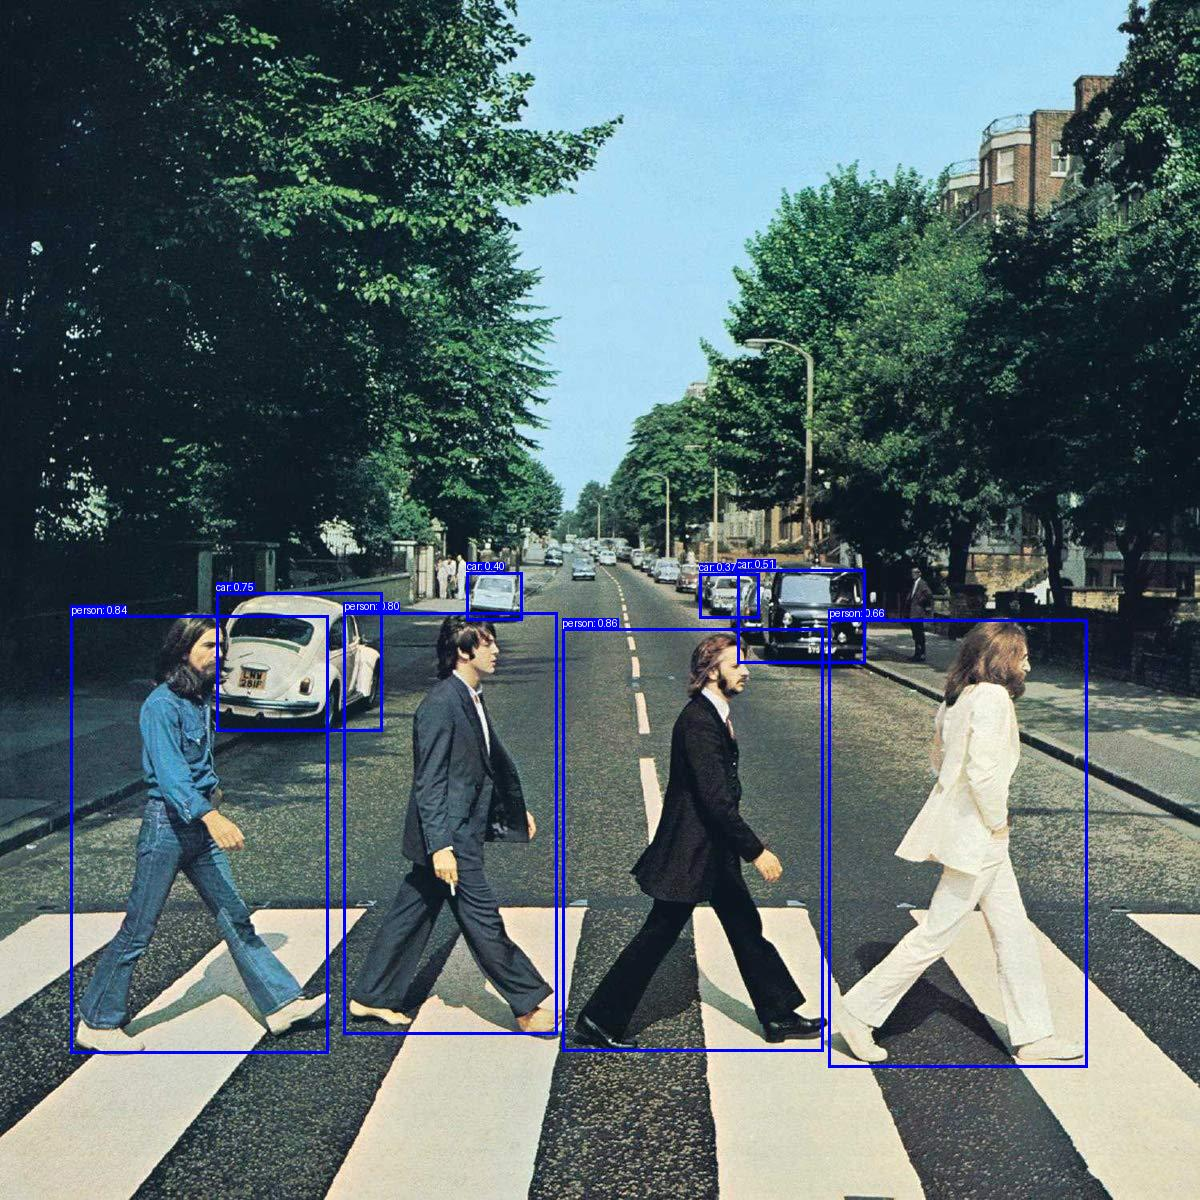

In [11]:
# ============================================================================
# STEP 8.5: Verification with ONNX Model on Abbey Road Image
# ============================================================================
print("\n" + "="*80)
print("STEP 8.5: Verifying ONNX output with Abbey Road image...")
print("="*80)

import onnxruntime as ort
ort_session = ort.InferenceSession(str(ONNX_PATH))

import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as IPyImage

# --- 1. Load Image and Run Inference ---
#test_image_path = "Beatles_-_Abbey_Road.jpg"
#if not Path(test_image_path).exists():
#    !wget -q https://upload.wikimedia.org/wikipedia/en/4/42/Beatles_-_Abbey_Road.jpg
test_image_path = "81sBKBIcwvL._SL1200_.jpg"
if not Path(test_image_path).exists():
    !wget -q https://m.media-amazon.com/images/I/81sBKBIcwvL._SL1200_.jpg

img = Image.open(test_image_path).convert("RGB")
original_size = img.size
print(f"Original image size: {original_size}")

# Resize to model input size
img_resized = img.resize(IMGSZ)
img_array_hwc = np.array(img_resized).astype(np.float32)
img_scale_factor = original_size[0] / IMGSZ[0]

# Convert to NCHW format for ONNX (CHW with batch dimension)
img_array_nchw = np.transpose(img_array_hwc, (2, 0, 1))[np.newaxis, :]  # [1, 3, H, W]
img_normalized = img_array_nchw / 255.0  # Normalize to [0, 1]

# Run ONNX inference
onnx_outputs = ort_session.run(None, {'images': img_normalized})

for i,o in enumerate(onnx_outputs):
    print(f"onnx_outputs[{i}].shape = {o.shape} , min = {o.min():.3f} , max = {o.max():.3f}")

boxes_xyxy_decoded = decode_dfl_boxes(onnx_outputs[0][0,:,:]) * img_scale_factor
#class_ids = onnx_outputs[1][0,:,:].squeeze()
#scores = 1 / (1+(np.exp(-1 * onnx_outputs[1][0,:,:].squeeze()))) # sigmoid
class_scores = 1 / (1+(np.exp(-1 * onnx_outputs[1][0,:,:].squeeze()))) # sigmoid
#boxes_xyxy = onnx_outputs[4][0,:,:] * img_scale_factor
class_ids_argmax = class_scores.argmax(axis=1)
scores_max = class_scores.max(axis=1)

# quantization investigation
#sum_logits = onnx_outputs[5][0,:,:].squeeze()
#inv_sum = onnx_outputs[6][0,:,:].squeeze()
#weights = onnx_outputs[7][0,:,:].squeeze()
#hbox = onnx_outputs[5][0,:,:].squeeze()
#distances = onnx_outputs[6][0,:,:].squeeze()

# --- 2. Process the Decoded Output ---
#print(f"boxes_xyxy (from TPU)[0:5]\n{boxes_xyxy[:5,:]}")
print(f"boxes_xyxy_decoded[0:5]\n{boxes_xyxy_decoded[:5,:]}")
#print(f"class_ids[0:5] (from TPU)\n{class_ids[:5]}") # calculated by TPU
print(f"class_ids_argmax[0:5]\n{class_ids_argmax[:5]}")
#print(f"scores[0:5] (from TPU)\n{scores[:5]}") # calculated by TPU
print(f"scores_max[0:5]\n{scores_max[:5]}")

#print("BOX[12] COORDINATES")
#print(f"boxes_xyxy (from TPU)[12]\n{boxes_xyxy[12,:]}")
#print(f"boxes_xyxy_decoded[12]\n{boxes_xyxy_decoded[12,:]}")


#unique_boxes_xyxy = np.unique(boxes_xyxy)
unique_boxes_xyxy_decoded = np.unique(boxes_xyxy_decoded)
#unique_class_ids = np.unique(class_ids)
unique_class_ids_argmax = np.unique(class_ids_argmax)
#unique_scores = np.unique(scores)
unique_scores_max = np.unique(scores_max)
print(f"\n✅ Score Precision Check:")
#print(f"   unique_boxes_xyxy: {len(unique_boxes_xyxy)}")
print(f"   unique_boxes_xyxy_decoded: {len(unique_boxes_xyxy_decoded)}")
#print(f"   unique_class_ids: {len(unique_class_ids)}")
print(f"   unique_class_ids_argmax: {len(unique_class_ids_argmax)}")
#print(f"   unique_scores: {len(unique_scores)}")
print(f"   unique_scores_max: {len(unique_scores_max)}")

#print(f"   sum_logits : min={sum_logits.min():.3f} , max={sum_logits.max():.3f} , unique vals: {len(np.unique(sum_logits))}")
#print(f"   inv_sum    : min={inv_sum.min():.3f} , max={inv_sum.max():.3f} , unique vals: {len(np.unique(inv_sum))}")
#print(f"   weights    : min={weights.min():.3f} , max={weights.max():.3f} , unique vals: {len(np.unique(weights))}")
#print(f"   hbox    : min={hbox.min():.3f} , max={hbox.max():.3f} , unique vals: {len(np.unique(hbox))}")
#print(f"   distances    : min={distances.min():.3f} , max={distances.max():.3f} , unique vals: {len(np.unique(distances))}")


conf_threshold = 0.25
#filtered_indices_tpu = scores > conf_threshold
#print(f"\nTPU: Found {np.sum(filtered_indices_tpu)} detections above {conf_threshold} confidence.")
if isinstance(scores_max, torch.Tensor):
    # .cpu() is important if the tensor is on the GPU
    scores_max = scores_max.cpu().numpy()
if isinstance(boxes_xyxy_decoded, torch.Tensor):
    boxes_xyxy_decoded = boxes_xyxy_decoded.cpu().numpy()
filtered_indices_cpu = (scores_max > conf_threshold) & \
    (boxes_xyxy_decoded[:,0] < boxes_xyxy_decoded[:,2]) & \
    (boxes_xyxy_decoded[:,1] < boxes_xyxy_decoded[:,3])
print(f"CPU: Found {filtered_indices_cpu.sum()} detections above {conf_threshold} confidence.")

#if np.sum(filtered_indices_tpu) > 0:
if np.sum(filtered_indices_cpu) > 0:
    #map_to_original_indices_tpu = np.where(filtered_indices_tpu)[0]
    map_to_original_indices_cpu = np.where(filtered_indices_cpu)[0]
    #filtered_boxes_xyxy = boxes_xyxy[filtered_indices_tpu]
    #filtered_scores = scores[filtered_indices_tpu]
    #filtered_class_ids = class_ids[filtered_indices_tpu]
    filtered_boxes_xyxy_cpu = boxes_xyxy_decoded[filtered_indices_cpu]
    filtered_scores_cpu = scores_max[filtered_indices_cpu]
    filtered_class_ids_cpu = class_ids_argmax[filtered_indices_cpu]
    filtered_class_scores_cpu = class_scores[filtered_indices_cpu]

    # --- 3. NMS & Drawing ---
    def nms(boxes, scores, iou_threshold):
        order = scores.argsort()[::-1]; keep = []
        while order.size > 0:
            i = order[0]; keep.append(i)
            xx1 = np.maximum(boxes[i, 0], boxes[order[1:], 0]); yy1 = np.maximum(boxes[i, 1], boxes[order[1:], 1])
            xx2 = np.minimum(boxes[i, 2], boxes[order[1:], 2]); yy2 = np.minimum(boxes[i, 3], boxes[order[1:], 3])
            w = np.maximum(0.0, xx2 - xx1); h = np.maximum(0.0, yy2 - yy1); inter = w * h
            ovr = inter / ((boxes[i, 2] - boxes[i, 0]) * (boxes[i, 3] - boxes[i, 1]) + (boxes[order[1:], 2] - boxes[order[1:], 0]) * (boxes[order[1:], 3] - boxes[order[1:], 1]) - inter + 1e-6)
            inds = np.where(ovr <= iou_threshold)[0]; order = order[inds + 1]
        return keep

    #nms_indices_tpu = nms(filtered_boxes_xyxy, filtered_scores, iou_threshold=0.45)
    #print(f"\nTPU Found {len(nms_indices_tpu)} detections after NMS.")
    nms_indices_cpu = nms(filtered_boxes_xyxy_cpu, filtered_scores_cpu, iou_threshold=0.45)
    print(f"CPU Found {len(nms_indices_cpu)} detections after NMS.")

    coco_classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
    draw = ImageDraw.Draw(img)
    #for nms_rank, i in enumerate(nms_indices_tpu):
    if False:
        original_index = map_to_original_indices_tpu[i]
        box = filtered_boxes_xyxy[i]
        label = f"{coco_classes[int(filtered_class_ids[i])]}: {filtered_scores[i]:.2f}"
        #label = f"{filtered_class_ids[i]:.1f}: {filtered_scores[i]:.2f}"
        draw.rectangle(box.tolist(), outline="red", width=3)
        text_bbox = draw.textbbox((box[0], box[1] - 12), label)
        draw.rectangle(text_bbox, fill="red")
        draw.text((box[0], box[1] - 12), label, fill="white")
        print(f"TPU box {original_index} class {filtered_class_ids[i]:.2f}:{coco_classes[int(filtered_class_ids[i])]} score {filtered_scores[i]:.5f} x1 {box[0]:.1f} y1 {box[1]:.1f} x2 {box[2]:.1f} y2 {box[3]:.1f}")
    for nms_rank, i in enumerate(nms_indices_cpu):
        original_index = map_to_original_indices_cpu[i]
        box = filtered_boxes_xyxy_cpu[i]
        label = f"{coco_classes[int(filtered_class_ids_cpu[i])]}: {filtered_scores_cpu[i]:.2f}"
        #label = f"{filtered_class_ids_cpu[i]}: {filtered_scores_cpu[i]:.2f}"
        draw.rectangle(box.tolist(), outline="blue", width=3)
        text_bbox = draw.textbbox((box[0], box[1] - 12), label)
        draw.rectangle(text_bbox, fill="blue")
        draw.text((box[0], box[1] - 12), label, fill="white")
        print(f"CPU box {original_index} class {coco_classes[int(filtered_class_ids_cpu[i])]} score {filtered_scores_cpu[i]:.5f} x1 {box[0]:.1f} y1 {box[1]:.1f} x2 {box[2]:.1f} y2 {box[3]:.1f}")
        #class_scores_to_print = [f"{float(x):.2f}" for x in filtered_class_scores_cpu[i]]
        #print(f"    box {i} class_scores: {class_scores_to_print}")

    # --- 4. Save and Display ---
    output_image_path = "detections_onnx.jpg"
    img.save(output_image_path)
    print(f"\n✓ Detections saved to '{output_image_path}'")
    display(IPyImage(filename=output_image_path))
else:
    print("⚠️  No detections found above confidence threshold.")

In [12]:
# ============================================================================
# STEP 10: Prepare Calibration Data (COCO128)
# ============================================================================
print("\n" + "="*80)
print("STEP 10: Preparing calibration data...")
print("="*80)

# Download and extract COCO128 if needed
if not Path("coco128.zip").exists():
    !wget -q https://ultralytics.com/assets/coco128.zip
    !unzip -q coco128.zip

print("\nLoading COCO128 dataset for calibration...")

# Simple image loader to replace YOLODataset
import cv2
from pathlib import Path
#import numpy as np
from glob import glob

# TODO: ensure that the min/max value for each tensor is represented
# box coordinates is probably OK
# class max scores may benefit from a 100% score
# class argmax depends on having class 0 and class NC-1 present !!
# those are 0:person (OK) and 16:bear (note that bear is class 21 in the original COCO label index)
# there is one photo of a bear in the coco128 data set:
# 000000000502.jpg so make sure this is included here. It is #92 in sorted order

# the coco128 labels have these counts of each category kept here:
coco_128_class_counts = """
    261 0
      6 1
     48 2
      6 3
      6 4
      7 5
      4 6
     12 7
      6 8
     16 14
      4 15
      9 16
      2 17
      0 18 <--- ZERO sheep
      0 19 <--- ZERO cow
     17 20 <--- elephant
      1 21 <--- bear
"""

def load_and_preprocess_image(img_path, target_size):
    """
    Load and preprocess an image for calibration.

    Args:
        img_path: Path to the image file
        target_size: Tuple of (height, width) for resizing

    Returns:
        Preprocessed image in HWC format (numpy array)
    """
    # Read image
    img = cv2.imread(str(img_path))
    if img is None:
        return None

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize with letterbox (maintain aspect ratio)
    h, w = img.shape[:2]
    target_h, target_w = target_size

    # Calculate scale to fit image within target size
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)

    # Resize image
    img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Create letterbox (padding)
    canvas = np.full((target_h, target_w, 3), 114, dtype=np.uint8)

    # Center the resized image on canvas
    top = (target_h - new_h) // 2
    left = (target_w - new_w) // 2
    canvas[top:top+new_h, left:left+new_w, :] = img_resized

    return canvas.astype(np.float32)

# Get all image files from COCO128
image_dir = Path('coco128/images/train2017')
image_files = sorted(glob(str(image_dir / '*.jpg')) + glob(str(image_dir / '*.png')))

if not image_files:
    raise RuntimeError(f"No images found in {image_dir}")

print(f"Found {len(image_files)} images in COCO128")

calibration_images = []

# Load and preprocess **ALL** 128 COCO images
num_coco_images = min(200, len(image_files))
print(f"Loading {num_coco_images} COCO images...")

for i in range(num_coco_images):
    img = load_and_preprocess_image(image_files[i], (IMGSZ[0], IMGSZ[1]))
    if img is not None:
        calibration_images.append(img)

    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{num_coco_images} images")

print(f"Successfully loaded {len(calibration_images)} COCO images")

# Add random noise images
print("Generating 50 random noise images...")
for i in range(50):
    # Generate random image with correct shape (no batch dimension)
    data = np.random.rand(IMGSZ[0], IMGSZ[1], 3).astype(np.float32) * 255
    calibration_images.append(data)

# Convert to arrays
calibration_images_uint8 = np.array(calibration_images).astype(np.uint8)
calibration_images_float32 = calibration_images_uint8.astype(np.float32)

# Save calibration data
CALIB_NPY = Path("coco128_calibration_images.npy")
np.save(str(CALIB_NPY), calibration_images_float32)

# Prepare calibration data for onnx2tf
np_data = [["images", str(CALIB_NPY), [[[[0, 0, 0]]]], [[[[255, 255, 255]]]]]]

print(f"\n✓ Created calibration data: {CALIB_NPY}")
print(f"  Shape: {calibration_images_float32.shape} (NHWC)")
print(f"  Dtype: {calibration_images_float32.dtype}")

# Calibration data verification
print(f"\n🔍 Calibration data verification:")
print(f"   Shape: {calibration_images_float32.shape}")
print(f"   Range: [{calibration_images_float32.min():.1f}, {calibration_images_float32.max():.1f}]")
print(f"   Mean: {calibration_images_float32.mean():.1f}")
print(f"   First image stats - min: {calibration_images_float32[0].min():.1f}, max: {calibration_images_float32[0].max():.1f}")
print(f"   Last image stats - min: {calibration_images_float32[-1].min():.1f}, max: {calibration_images_float32[-1].max():.1f}")


STEP 10: Preparing calibration data...

Loading COCO128 dataset for calibration...
Found 128 images in COCO128
Loading 128 COCO images...
  Processed 10/128 images
  Processed 20/128 images
  Processed 30/128 images
  Processed 40/128 images
  Processed 50/128 images
  Processed 60/128 images
  Processed 70/128 images
  Processed 80/128 images
  Processed 90/128 images
  Processed 100/128 images
  Processed 110/128 images
  Processed 120/128 images
Successfully loaded 128 COCO images
Generating 50 random noise images...

✓ Created calibration data: coco128_calibration_images.npy
  Shape: (178, 320, 320, 3) (NHWC)
  Dtype: float32

🔍 Calibration data verification:
   Shape: (178, 320, 320, 3)
   Range: [0.0, 255.0]
   Mean: 115.8
   First image stats - min: 0.0, max: 255.0
   Last image stats - min: 0.0, max: 254.0


In [13]:
# =======================================================================================
# STEPS 11 & 12: Convert to TFLite using official TFLiteConverter
# =======================================================================================
print("\n" + "="*80)
print("STEPS 11 & 12: Converting and Quantizing with TFLiteConverter")
print("="*80)

# Step 1: Create SavedModel using onnx2tf (without quantization)
SAVEDMODEL_FOLDER = Path(MODEL_PATH).stem + "_savedmodel"
if Path(SAVEDMODEL_FOLDER).exists():
    import shutil
    shutil.rmtree(SAVEDMODEL_FOLDER)

print("Step 1: Converting ONNX to TensorFlow SavedModel...")
min_range_val = np.array([[[[0, 0, 0]]]], dtype=np.float32)
max_range_val = np.array([[[[255, 255, 255]]]], dtype=np.float32)
np_data = [
    ["images", str(CALIB_NPY), min_range_val, max_range_val]
]

onnx2tf.convert(
    input_onnx_file_path=str(ONNX_PATH),
    output_folder_path=SAVEDMODEL_FOLDER,
    output_integer_quantized_tflite=False,  # Don't quantize yet
    custom_input_op_name_np_data_path=np_data,
    not_use_onnxsim=True,
    verbosity='error',
    output_signaturedefs=True,
    disable_group_convolution=True,
    batch_size=1,
    copy_onnx_input_output_names_to_tflite=True, # does not work -?
    # see -coion notes here https://github.com/PINTO0309/onnx2tf
    # or do later (yuck) https://github.com/PINTO0309/onnx2tf?tab=readme-ov-file#5-rewriting-of-tflite-inputoutput-op-names-and-signature_defs
)

savedmodel_path = Path(SAVEDMODEL_FOLDER)
print(f"✓ SavedModel created at: {savedmodel_path}")

if True:
    # Step 2: Quantize using official TFLiteConverter
    # This is faster than onnx2tf. both seem to succeed.
    print("\nStep 2: Quantizing with official TFLiteConverter...")

    # Load calibration data
    calib_images = np.load(str(CALIB_NPY))

    def representative_dataset():
        for i in range(len(calib_images)):
            img = calib_images[i:i+1] / 255.0
            yield [img.astype(np.float32)]

    # Convert with official TFLiteConverter
    converter = tf.lite.TFLiteConverter.from_saved_model(str(savedmodel_path))
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.int8

    print("  Quantizing model (this may take 1-2 minutes)...")
    tflite_model = converter.convert()

    # Save quantized model
    int8_tflite = Path(f"{Path(MODEL_PATH).stem}_{IMGSZ[0]}_int8.tflite")
    with open(int8_tflite, 'wb') as f:
        f.write(tflite_model)
else:
    int8_tflite = Path(f"/content/yolov9-s-relu6-best_savedmodel/yolov9-s-relu6-best_full_integer_quant.tflite")


size_mb = int8_tflite.stat().st_size / 1024 / 1024
print(f"\n✓ INT8 TFLite model created: {int8_tflite}")
print(f"  Size: {size_mb:.2f} MB")

# Cleanup SavedModel folder to save space (optional)
# shutil.rmtree(SAVEDMODEL_FOLDER)


STEPS 11 & 12: Converting and Quantizing with TFLiteConverter
Step 1: Converting ONNX to TensorFlow SavedModel...
Saved artifact at 'yolov9-s-relu6-best_savedmodel'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 320, 320, 3), dtype=tf.float32, name='images')
Output Type:
  List[TensorSpec(shape=(1, 2100, 64), dtype=tf.float32, name=None), TensorSpec(shape=(1, 2100, 17), dtype=tf.float32, name=None)]
Captures:
  134412922613648: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  134412922614608: TensorSpec(shape=(3, 3, 3, 32), dtype=tf.float32, name=None)
  134412922612880: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  134412922610576: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  134412922609232: TensorSpec(shape=(3, 3, 32, 64), dtype=tf.float32, name=None)
  134412922606544: TensorSpec(shape=(64,), dtype=tf.float32, name=None)
  134412922607120: TensorSpec(shape=(1, 1, 64, 64), dtype=tf.floa

In [14]:
# ============================================================================
# STEP 13: Verify Quantization
# ============================================================================
print("\n" + "="*80)
print("STEP 13: Verifying quantization...")
print("="*80)

# temporary
#int8_tflite = savedmodel_path / "yolov9-s-relu6-best_full_integer_quant.tflite"
#int8_tflite = Path(f"{Path(MODEL_PATH).stem}_{IMGSZ[0]}_int8.tflite")

print(f"tflite model file {int8_tflite}")
interpreter = tf.lite.Interpreter(model_path=str(int8_tflite)) # onnx2tf version
#sigrunner = interpreter.get_signature_runner()
#print("Signature Inputs:", sigrunner.get_input_details().keys())
#print("Signature Outputs:", sigrunner.get_output_details().keys())

interpreter.allocate_tensors()

signatures = interpreter.get_signature_list()
print(signatures)

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"\n📥 Input:")
print(f"   Index: {input_details[0]['index']}")
print(f"   Name: {input_details[0]['name']}")
print(f"   Type: {input_details[0]['dtype']}")
print(f"   Shape: {input_details[0]['shape']}")
print(f"   Quantization: scale={input_details[0]['quantization'][0]:.6f}, "
      f"zero_point={input_details[0]['quantization'][1]}")

for n in range(len(output_details)):
    print(f"\n📤 Output {n}:")
    print(f"   Index: {output_details[n]['index']}")
    print(f"   Name: {output_details[n]['name']}")
    print(f"   Type: {output_details[n]['dtype']}")
    print(f"   Shape: {output_details[n]['shape']}")
    print(f"   Quantization: scale={output_details[n]['quantization'][0]:.6f}, "
          f"zero_point={output_details[n]['quantization'][1]}")

tensor_details = interpreter.get_tensor_details()
non_int8 = [t for t in tensor_details if t['dtype'] not in [np.int8, np.uint8]]

print(f"\n🔍 Tensor Analysis:")
print(f"   Total tensors: {len(tensor_details)}")
print(f"   INT8/UINT8 tensors: {len(tensor_details) - len(non_int8)}")
print(f"   Non-INT8 tensors: {len(non_int8)}")

if non_int8:
    print(f"\n❌ WARNING: Found {len(non_int8)} non-INT8 tensors! (might be OK)")
    for i, t in enumerate(non_int8[:5]):
        print(f"   {i+1}. {t['name']}: {t['dtype']}, shape={t['shape']}")
else:
    print(f"\n✅ SUCCESS: All tensors are INT8/UINT8!")
    print("   Model is quantized for EdgeTPU")


STEP 13: Verifying quantization...
tflite model file yolov9-s-relu6-best_320_int8.tflite
{'serving_default': {'inputs': ['images'], 'outputs': ['output_0', 'output_1']}}

📥 Input:
   Index: 0
   Name: serving_default_images:0
   Type: <class 'numpy.uint8'>
   Shape: [  1 320 320   3]
   Quantization: scale=0.003922, zero_point=0

📤 Output 0:
   Index: 787
   Name: PartitionedCall:1
   Type: <class 'numpy.int8'>
   Shape: [   1 2100   17]
   Quantization: scale=0.028768, zero_point=11

📤 Output 1:
   Index: 780
   Name: PartitionedCall:0
   Type: <class 'numpy.int8'>
   Shape: [   1 2100   64]
   Quantization: scale=0.080557, zero_point=-46

🔍 Tensor Analysis:
   Total tensors: 788
   INT8/UINT8 tensors: 567
   Non-INT8 tensors: 221

❌ WARNING: Found 221 non-INT8 tensors! (might be OK)
   1. arith.constant: <class 'numpy.int32'>, shape=[4 2]
   2. arith.constant1: <class 'numpy.int32'>, shape=[4]
   3. arith.constant2: <class 'numpy.int32'>, shape=[4]
   4. arith.constant3: <class 'num

# INT8 Test Abbey Road


STEP 14.5: Verification with real image and XYWH Box and PROB Score Outputs...
Resizing to (320, 320)
tflite_outputs[0].shape = (1, 2100, 17) , min = -3.999 , max = 1.784
tflite_outputs[1].shape = (1, 2100, 64) , min = -5.397 , max = 13.453
boxes_dfl.shape = torch.Size([2100, 64])
transposing boxes_dfl
boxes_dfl.shape = torch.Size([64, 2100])
boxes_xyxy_decoded[0:5]
tensor([[  0.00000,   0.00000,  81.51700, 142.48100],
        [  0.00000,   0.00000, 172.76675, 152.71349],
        [  0.00000,   0.00000, 237.64046, 110.86037],
        [  6.23018,   0.00000, 275.77612, 120.63554],
        [112.97264,   1.64132, 231.60574,  51.69906]])
class_ids_argmax[0:5]
[0 0 0 0 0]

✅ Score Precision Check:
   unique_boxes_xyxy_decoded: 7618
   unique_class_ids_argmax: 2
   unique_scores_max: 71
CPU: Found 63 detections above 0.25 confidence.
CPU Found 9 detections after NMS.
CPU box 1931 class person score 0.85614 x1 561.5 y1 629.9 x2 824.3 y2 1051.4
CPU box 1902 class person score 0.84138 x1 71.3 y1

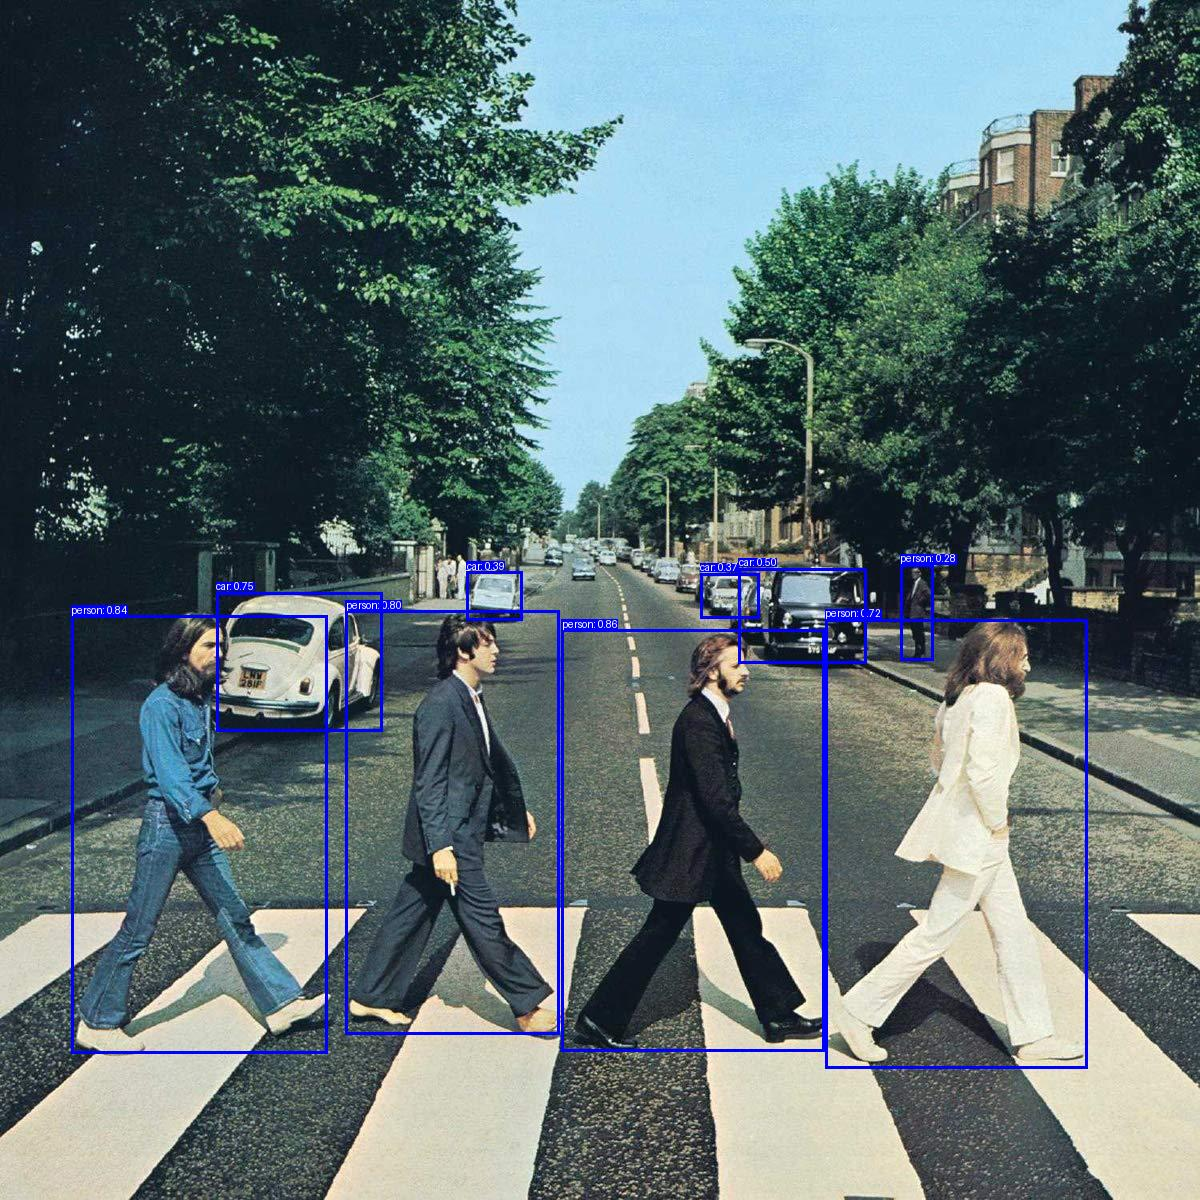

In [15]:
# ============================================================================
# STEP 14.5: Verification with real image and XYWH Box and PROB Score Outputs
# ============================================================================
print("\n" + "="*80)
print("STEP 14.5: Verification with real image and XYWH Box and PROB Score Outputs...")
print("="*80)

import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as IPyImage

# --- 1. Load Image and Run Inference ---
#test_image_path = "Beatles_-_Abbey_Road.jpg"
#if not Path(test_image_path).exists():
#    !wget -q https://upload.wikimedia.org/wikipedia/en/4/42/Beatles_-_Abbey_Road.jpg
test_image_path = "81sBKBIcwvL._SL1200_.jpg"
#test_image_path = "coco128/images/train2017/000000000502.jpg" # bear for testing class index range coverage
# warning: the bear picture is 640x427, not a square
#if not Path(test_image_path).exists():
#    !wget -q https://m.media-amazon.com/images/I/81sBKBIcwvL._SL1200_.jpg

img = Image.open(test_image_path).convert("RGB")
original_size = img.size
print(f"Resizing to {repr(IMGSZ)}")
img_scale_factor = original_size[0] / IMGSZ[0]

img_resized = img.resize(IMGSZ)
img_array_nhwc = np.array(img_resized).astype(np.float32)
img_batch = np.expand_dims(img_array_nhwc, axis=0)

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_scale, input_zero_point = input_details[0]['quantization']
input_data_int8 = (img_batch / 255.0 / input_scale + input_zero_point).astype(np.uint8)
#input_data_int8 = (img_batch / 255.0 / input_scale + input_zero_point).astype(np.int8)
interpreter.set_tensor(input_details[0]['index'], input_data_int8)
interpreter.invoke()
output_details = interpreter.get_output_details()

tflite_outputs = []
for detail in output_details:
    int8_data = interpreter.get_tensor(detail['index'])
    shape = tuple([int(x) for x in detail['shape']])
    dtype = detail['dtype']
    name = detail['name']
    #print(f"DEBUG anchor_count:{anchor_count} found output with shape {shape}")
    #print(f"DEBUG tensor output found with shape {detail['shape']} and dtype {detail['dtype']}")
    scale, zero_point = detail['quantization']
    if scale < 0.00000001:
        #print(f"DEBUG not scaling output")
        scaled_output = int8_data.astype(np.float32)
    else:
        #print(f"DEBUG scaling output with zeropoint {zero_point} and scale {scale}")
        scaled_output = (int8_data.astype(np.float32) - zero_point) * scale
    tflite_outputs.append(scaled_output)

for i,o in enumerate(tflite_outputs):
    print(f"tflite_outputs[{i}].shape = {o.shape} , min = {o.min():.3f} , max = {o.max():.3f}")

# 1,0,2 for accessing original order of 3-tensor output
# 3,1,4,2,0 is the id for each respective call when using 5 tensor output
# 5,1,6,4,0,3,7,2 is the id for each when using 8 tensor output for quantization investigation
# 4,1,5,3,0,2,6 when 7 tensor output

dfl_weights = tflite_outputs[1][0,:,:]
boxes_xyxy_decoded = decode_dfl_boxes(dfl_weights) * img_scale_factor
boxes_xyxy_decoded = boxes_xyxy_decoded.clamp(0,IMGSZ[0] * img_scale_factor)
#class_ids = tflite_outputs[1][0,:,:].squeeze()
#scores = 1 / (1+(np.exp(-1 * tflite_outputs[0][0,:,:].squeeze()))) # sigmoid
class_scores = 1 / (1+(np.exp(-1 * tflite_outputs[0][0,:,:].squeeze()))) # sigmoid
#boxes_xyxy = tflite_outputs[0][0,:,:] * img_scale_factor
class_ids_argmax = class_scores.argmax(axis=1)
scores_max = class_scores.max(axis=1)

# quantization investigation
#sum_logits = tflite_outputs[3][0,:,:].squeeze()
#inv_sum = tflite_outputs[7][0,:,:].squeeze()
#weights = tflite_outputs[2][0,:,:].squeeze()
#hbox = tflite_outputs[2][0,:,:].squeeze()
#distances = tflite_outputs[6][0,:,:].squeeze()

# --- 2. Process the Decoded Output ---
#print(f"boxes_xyxy (from TPU)[0:5]\n{boxes_xyxy[:5,:]}")
print(f"boxes_xyxy_decoded[0:5]\n{boxes_xyxy_decoded[:5,:]}")
#print(f"class_ids[0:5] (from TPU)\n{class_ids[:5]}") # calculated by TPU
print(f"class_ids_argmax[0:5]\n{class_ids_argmax[:5]}")
#print(f"scores[0:5] (from TPU)\n{scores[:5]}") # calculated by TPU
#print(f"scores_max[0:5]\n{scores_max[:5]}")

#if len(boxes_xyxy) > 12:
#    print("BOX[12] COORDINATES")
#    print(f"boxes_xyxy (from TPU)[12]\n{boxes_xyxy[12,:]}")
#    print(f"boxes_xyxy_decoded[12]\n{boxes_xyxy_decoded[12,:]}")

#unique_boxes_xyxy = np.unique(boxes_xyxy)
unique_boxes_xyxy_decoded = np.unique(boxes_xyxy_decoded)
#unique_class_ids = np.unique(class_ids)
unique_class_ids_argmax = np.unique(class_ids_argmax)
#unique_scores = np.unique(scores)
unique_scores_max = np.unique(scores_max)
print(f"\n✅ Score Precision Check:")
#print(f"   unique_boxes_xyxy: {len(unique_boxes_xyxy)}")
print(f"   unique_boxes_xyxy_decoded: {len(unique_boxes_xyxy_decoded)}")
#print(f"   unique_class_ids: {len(unique_class_ids)}")
print(f"   unique_class_ids_argmax: {len(unique_class_ids_argmax)}")
#print(f"   unique_scores: {len(unique_scores)}")
print(f"   unique_scores_max: {len(unique_scores_max)}")

#print(f"   sum_logits : min={sum_logits.min():.3f} , max={sum_logits.max():.3f} , unique vals: {len(np.unique(sum_logits))}")
#print(f"   inv_sum    : min={inv_sum.min():.3f} , max={inv_sum.max():.3f} , unique vals: {len(np.unique(inv_sum))}")
#print(f"   weights    : min={weights.min():.3f} , max={weights.max():.3f} , unique vals: {len(np.unique(weights))}")
#print(f"   hbox       : min={hbox.min():.3f} , max={hbox.max():.3f} , unique vals: {len(np.unique(hbox))}")


conf_threshold = 0.25
#filtered_indices_tpu = scores > conf_threshold
#print(f"\nTPU: Found {np.sum(filtered_indices_tpu)} detections above {conf_threshold} confidence.")
if isinstance(scores_max, torch.Tensor):
    # .cpu() is important if the tensor is on the GPU
    scores_max = scores_max.cpu().numpy()
if isinstance(boxes_xyxy_decoded, torch.Tensor):
    boxes_xyxy_decoded = boxes_xyxy_decoded.cpu().numpy()
filtered_indices_cpu = (scores_max > conf_threshold) & \
    (boxes_xyxy_decoded[:,0] < boxes_xyxy_decoded[:,2]) & \
    (boxes_xyxy_decoded[:,1] < boxes_xyxy_decoded[:,3])
print(f"CPU: Found {filtered_indices_cpu.sum()} detections above {conf_threshold} confidence.")

if np.sum(filtered_indices_cpu) > 0:
    #map_to_original_indices_tpu = np.where(filtered_indices_tpu)[0]
    map_to_original_indices_cpu = np.where(filtered_indices_cpu)[0]
    #filtered_boxes_xyxy = boxes_xyxy[filtered_indices_tpu]
    #filtered_scores = scores[filtered_indices_tpu]
    #filtered_class_ids = class_ids[filtered_indices_tpu]
    filtered_boxes_xyxy_cpu = boxes_xyxy_decoded[filtered_indices_cpu]
    filtered_scores_cpu = scores_max[filtered_indices_cpu]
    filtered_class_ids_cpu = class_ids_argmax[filtered_indices_cpu]
    filtered_class_scores_cpu = class_scores[filtered_indices_cpu]

    # --- 3. NMS & Drawing ---
    def nms(boxes, scores, iou_threshold):
        order = scores.argsort()[::-1]; keep = []
        while order.size > 0:
            i = order[0]; keep.append(i)
            xx1 = np.maximum(boxes[i, 0], boxes[order[1:], 0]); yy1 = np.maximum(boxes[i, 1], boxes[order[1:], 1])
            xx2 = np.minimum(boxes[i, 2], boxes[order[1:], 2]); yy2 = np.minimum(boxes[i, 3], boxes[order[1:], 3])
            w = np.maximum(0.0, xx2 - xx1); h = np.maximum(0.0, yy2 - yy1); inter = w * h
            ovr = inter / ((boxes[i, 2] - boxes[i, 0]) * (boxes[i, 3] - boxes[i, 1]) + (boxes[order[1:], 2] - boxes[order[1:], 0]) * (boxes[order[1:], 3] - boxes[order[1:], 1]) - inter + 1e-6)
            inds = np.where(ovr <= iou_threshold)[0]; order = order[inds + 1]
        return keep

    #nms_indices_tpu = nms(filtered_boxes_xyxy, filtered_scores, iou_threshold=0.45)
    #print(f"\nTPU Found {len(nms_indices_tpu)} detections after NMS.")
    nms_indices_cpu = nms(filtered_boxes_xyxy_cpu, filtered_scores_cpu, iou_threshold=0.45)
    #nms_indices_cpu.append(20) # temporary for investigation of errant bicycle detection
    print(f"CPU Found {len(nms_indices_cpu)} detections after NMS.")

    coco_classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
    draw = ImageDraw.Draw(img)
    #for nms_rank, i in enumerate(nms_indices_tpu):
    if False:
        original_index = map_to_original_indices_tpu[i]
        box = filtered_boxes_xyxy[i]
        if (box[2] <= box[0]) or (box[3] <= box[1]):
            print(f"TPU box {original_index} class {filtered_class_ids[i]:.2f}:{coco_classes[int(filtered_class_ids[i])]} score {filtered_scores[i]:.5f} INVALID COORDINATES! x1 {box[0]:.1f} y1 {box[1]:.1f} x2 {box[2]:.1f} y2 {box[3]:.1f}")
            #continue
        label = f"{coco_classes[int(filtered_class_ids[i])]}: {filtered_scores[i]:.2f}"
        #label = f"{filtered_class_ids[i]:.1f}: {filtered_scores[i]:.2f}"
        draw.rectangle(box.tolist(), outline="red", width=3)
        text_bbox = draw.textbbox((box[0], box[1] - 12), label)
        draw.rectangle(text_bbox, fill="red")
        draw.text((box[0], box[1] - 12), label, fill="white")
        print(f"TPU box {original_index} class {filtered_class_ids[i]:.2f}:{coco_classes[int(filtered_class_ids[i])]} score {filtered_scores[i]:.5f} x1 {box[0]:.1f} y1 {box[1]:.1f} x2 {box[2]:.1f} y2 {box[3]:.1f}")
    for nms_rank, i in enumerate(nms_indices_cpu):
        original_index = map_to_original_indices_cpu[i]
        box = filtered_boxes_xyxy_cpu[i]
        label = f"{coco_classes[int(filtered_class_ids_cpu[i])]}: {filtered_scores_cpu[i]:.2f}"
        #label = f"{filtered_class_ids_cpu[i]}: {filtered_scores_cpu[i]:.2f}"
        draw.rectangle(box.tolist(), outline="blue", width=3)
        text_bbox = draw.textbbox((box[0], box[1] - 12), label)
        draw.rectangle(text_bbox, fill="blue")
        draw.text((box[0], box[1] - 12), label, fill="white")
        print(f"CPU box {original_index} class {coco_classes[int(filtered_class_ids_cpu[i])]} score {filtered_scores_cpu[i]:.5f} x1 {box[0]:.1f} y1 {box[1]:.1f} x2 {box[2]:.1f} y2 {box[3]:.1f}")
        #class_scores_to_print = [f"{float(x):.2f}" for x in filtered_class_scores_cpu[i]]
        #print(f"    box {i} class_scores: {class_scores_to_print}")

    #for i, box in enumerate(decoded_boxes_xyxy):
    #    print(f"box {i} class {valid_class_ids[i]} score {valid_scores[i]:.5f} {'NMS ' if i in nms_indices else ''} x1 {box[0]:.1f} y1 {box[1]:.1f} x2 {box[2]:.1f} y2 {box[3]:.1f}")

    #print("\nLOOKING FOR BOXES WITH LARGE DIFFERENCES TPU vs CPU\n")
    #for i in range(min(5,boxes_xyxy.shape[0])):
    if False:
        tpubox = boxes_xyxy[i]
        cpubox = boxes_xyxy_decoded[i]
        diffs = [abs(tpubox[j] -  cpubox[j]) for j in range(4)]
        stridefactor = 8 if i < 1600 else (16 if i < 2000 else 32)
        max_diff = max(diffs)
        max_diff_normalized = max_diff / stridefactor
        if max_diff_normalized > 10:
            print(f"box {i} : diff_norm {max_diff_normalized:.1f} : diff_pixels {max_diff:.1f} : TPU {tpubox} , CPU {cpubox}")


    # --- 4. Save and Display ---
    output_image_path = "detections_separate_outputs.jpg"
    img.save(output_image_path)
    print(f"\n✓ Detections saved to '{output_image_path}'")
    display(IPyImage(filename=output_image_path))

In [16]:
# ============================================================================
# STEP 15pre: Install EdgeTPU Compiler (Linux only)
# ============================================================================
print("\nInstalling Edge TPU Compiler...")
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
!sudo apt-get update -q
!sudo apt-get install -q -y edgetpu-compiler

print("✓ EdgeTPU Compiler installed!")


Installing Edge TPU Compiler...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0   8183      0 --:--:-- --:--:-- --:--:--  8176
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://cli.github.com/packages stable InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [1,423 B]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InReleas

In [17]:
# ============================================================================
# STEP 15: Compile model for EdgeTPU
# ============================================================================
print("\n" + "="*80)
print("STEP 15: Compile model for EdgeTPU...")
print("="*80)

EDGETPU_OUTPUT = int8_tflite.parent / f"{Path(MODEL_PATH).stem}_edgetpu.tflite"

# Run Edge TPU compiler
cmd = [
    "edgetpu_compiler",
    str(int8_tflite),
    "-o", str(int8_tflite.parent),
    "--show_operations",
    "--search_delegate",
    "--delegate_search_step", "30",
    "--timeout_sec", "180",
    #"-a"
]

print(f"Running: {' '.join(cmd)}")
result = subprocess.run(cmd, capture_output=True, text=True)

print(result.stdout)
if result.returncode != 0:
    print("ERROR:", result.stderr)
    raise RuntimeError("Edge TPU compilation failed")

# Find the compiled EdgeTPU model
#edgetpu_files = list(int8_tflite.parent.glob("*_edgetpu.tflite"))
#if not edgetpu_files:
#    raise ValueError("EdgeTPU compiled file not found")
#
#final_edgetpu_model = edgetpu_files[0]
#print(f"\n✓ Edge TPU model created: {final_edgetpu_model}")
#print(f"  Size: {final_edgetpu_model.stat().st_size / 1024:.1f} KB")


STEP 15: Compile model for EdgeTPU...
Running: edgetpu_compiler yolov9-s-relu6-best_320_int8.tflite -o . --show_operations --search_delegate --delegate_search_step 30 --timeout_sec 180
Edge TPU Compiler version 16.0.384591198
Searching for valid delegate with step 30
Try to compile segment with 333 ops
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 5966 ms.

Input model: yolov9-s-relu6-best_320_int8.tflite
Input size: 7.23MiB
Output model: ./yolov9-s-relu6-best_320_int8_edgetpu.tflite
Output size: 7.80MiB
On-chip memory used for caching model parameters: 7.23MiB
On-chip memory remaining for caching model parameters: 768.00B
Off-chip memory used for streaming uncached model parameters: 385.38KiB
Number of Edge TPU subgraphs: 1
Total number of operations: 333
Operation log: ./yolov9-s-relu6-best_320_int8_edgetpu.log

Operator                       Count      Status

ADD                            48         Mapped to Edge TPU
MAX_POOL_2D             